In [79]:
import bayes_opt
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.util import load_logs

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

import json

%matplotlib inline

In [66]:
# code taken from BayesianOptimization module notebook:
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb
def posterior(optimizer, x_obs, y_obs, grid):
  optimizer._gp.fit(x_obs, y_obs)

  mu, sigma = optimizer._gp.predict(grid, return_std=True)
  return mu, sigma

def plot_gp(optimizer, utility, command_params, paramName):
  x_lims = command_params[paramName]
  x = np.linspace(x_lims[0], x_lims[1], 10000).reshape(-1, 1)
  fig = plt.figure(figsize=(16, 10))
  steps = len(optimizer.space)
  fig.suptitle(
    'Gaussian Process and Utility Function for Param {} After {} Steps'.format(paramName, steps),
    fontdict={'size':30}
  )

  gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
  axis = plt.subplot(gs[0])
  acq = plt.subplot(gs[1])

  x_obs = np.array([[res["params"][paramName]] for res in optimizer.res])
  y_obs = np.array([res["target"] for res in optimizer.res])

  mu, sigma = posterior(optimizer, x_obs, y_obs, x)
  axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
  axis.plot(x, mu, '--', color='k', label='Prediction')

  axis.fill(np.concatenate([x, x[::-1]]), 
    np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
    alpha=.6, fc='c', ec='None', label='95% confidence interval')

  axis.set_xlim(x_lims)
  axis.set_ylim((None, None))
  axis.set_ylabel('f(x)', fontdict={'size':20})
  axis.set_xlabel('x', fontdict={'size':20})

  utility_function = utility
  utility = utility_function.utility(x, optimizer._gp, 0)
  acq.plot(x, utility, label='Utility Function', color='purple')
  acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
    label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
  acq.set_xlim((-2, 10))
  acq.set_ylim((0, np.max(utility) + 0.5))
  acq.set_ylabel('Utility', fontdict={'size':20})
  acq.set_xlabel('x', fontdict={'size':20})

  axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
  acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

  # plt.savefig(os.path.dirname(os.path.realpath(__file__)) + '/paropt_steps-{}_param-{}.png'.format(steps, paramName))

In [67]:
params = {
  'nCPUs': (2, 24),
  'memPerCPU': (8, 32)
}

optimizer = BayesianOptimization(
  f=None,
  pbounds=params,
  verbose=2,
  random_state=1,
)

load_logs(optimizer, logs=["./bayes_logs.json"]);

orig_utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [68]:
# previously evaluated 6, 18 and 3, 8 (ncpus, mempercpu)
# had problem where it suggested 6, 18 again
# maybe it's due to our kappa value - the "explore vs. exploit" parameter of evaulting utility
kappaVals=np.arange(2, 100, 10)
for k in kappaVals:
    tmp_util = UtilityFunction(kind="ucb", kappa=k, xi=0.0)
    print(f"kapp: {k}, suggestion: {optimizer.suggest(tmp_util)}")

kapp: 2, suggestion: {'memPerCPU': 18.008409299927195, 'nCPUs': 6.3220209946439825}
kapp: 12, suggestion: {'memPerCPU': 18.009979227496054, 'nCPUs': 6.3227050803873714}
kapp: 22, suggestion: {'memPerCPU': 18.010551973301254, 'nCPUs': 6.324192813354266}
kapp: 32, suggestion: {'memPerCPU': 18.004165388276018, 'nCPUs': 6.322551557622431}
kapp: 42, suggestion: {'memPerCPU': 18.002778149736827, 'nCPUs': 6.321318315877648}
kapp: 52, suggestion: {'memPerCPU': 18.009691320589166, 'nCPUs': 6.329015331548249}
kapp: 62, suggestion: {'memPerCPU': 18.00016869827407, 'nCPUs': 6.323705318993872}
kapp: 72, suggestion: {'memPerCPU': 18.01284703271494, 'nCPUs': 6.330878566379745}
kapp: 82, suggestion: {'memPerCPU': 18.001915100345595, 'nCPUs': 6.33110925190316}
kapp: 92, suggestion: {'memPerCPU': 18.020759330405866, 'nCPUs': 6.318611272272176}


In [69]:
# in the examples from the bayes opt package, they used pretty small kappa (1 to 10)
# but maybe it's relative to the difference in the values you're optimizing...
# with mine, the difference is -12511 - -15922 = 3400

# looks like if I bump kappa up to ~30K or 40K it is moving around a bit more.
kappaVals=np.arange(2, 100000, 10000)
for k in kappaVals:
    tmp_util = UtilityFunction(kind="ucb", kappa=k, xi=0.0)
    print(f"kapp: {k}, suggestion: {optimizer.suggest(tmp_util)}")

kapp: 2, suggestion: {'memPerCPU': 18.008673377007796, 'nCPUs': 6.321958931955716}
kapp: 10002, suggestion: {'memPerCPU': 18.398430348150377, 'nCPUs': 6.734409521557648}
kapp: 20002, suggestion: {'memPerCPU': 17.47398032212049, 'nCPUs': 6.779038249161925}
kapp: 30002, suggestion: {'memPerCPU': 17.389907067654974, 'nCPUs': 6.7965078895251105}
kapp: 40002, suggestion: {'memPerCPU': 18.23761362168565, 'nCPUs': 5.521400514053913}
kapp: 50002, suggestion: {'memPerCPU': 17.33772293797916, 'nCPUs': 6.880958783896762}
kapp: 60002, suggestion: {'memPerCPU': 18.35282560924171, 'nCPUs': 7.1599291322576715}
kapp: 70002, suggestion: {'memPerCPU': 18.845379834043452, 'nCPUs': 6.735421142810973}
kapp: 80002, suggestion: {'memPerCPU': 18.387942670081735, 'nCPUs': 5.443304434954919}
kapp: 90002, suggestion: {'memPerCPU': 17.251088392232152, 'nCPUs': 5.7035846642715695}


In [70]:
# but on second thought I realize that it's probably not wanting to move anywhere
# because of it's fit.
# see plots below

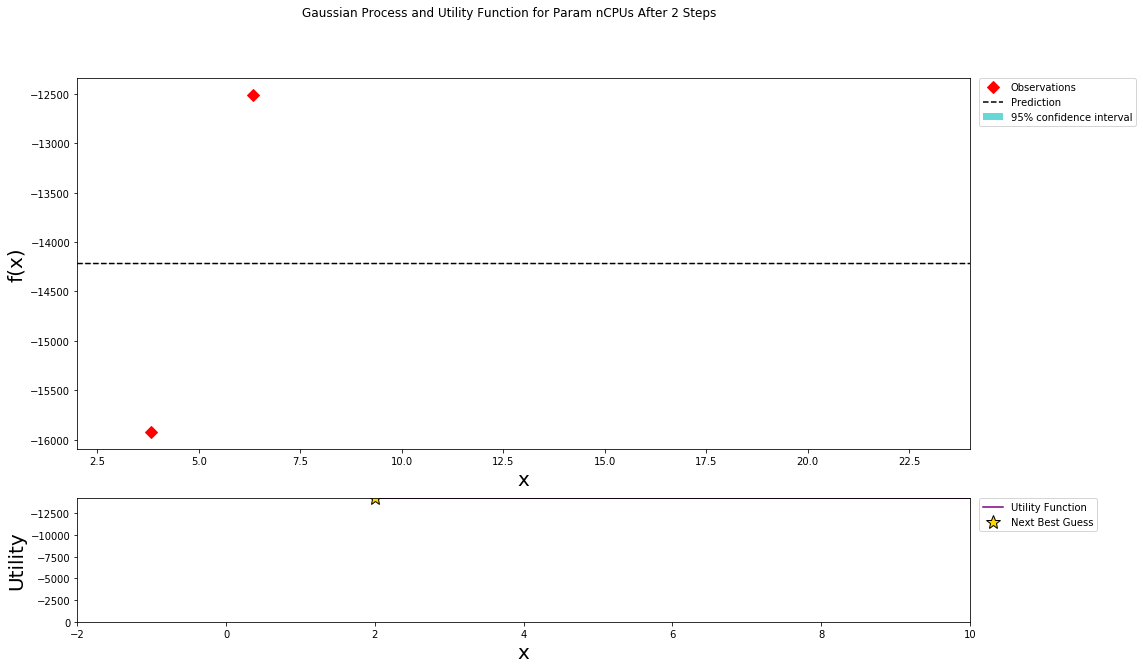

In [71]:
plot_gp(optimizer, orig_utility, params, 'nCPUs')

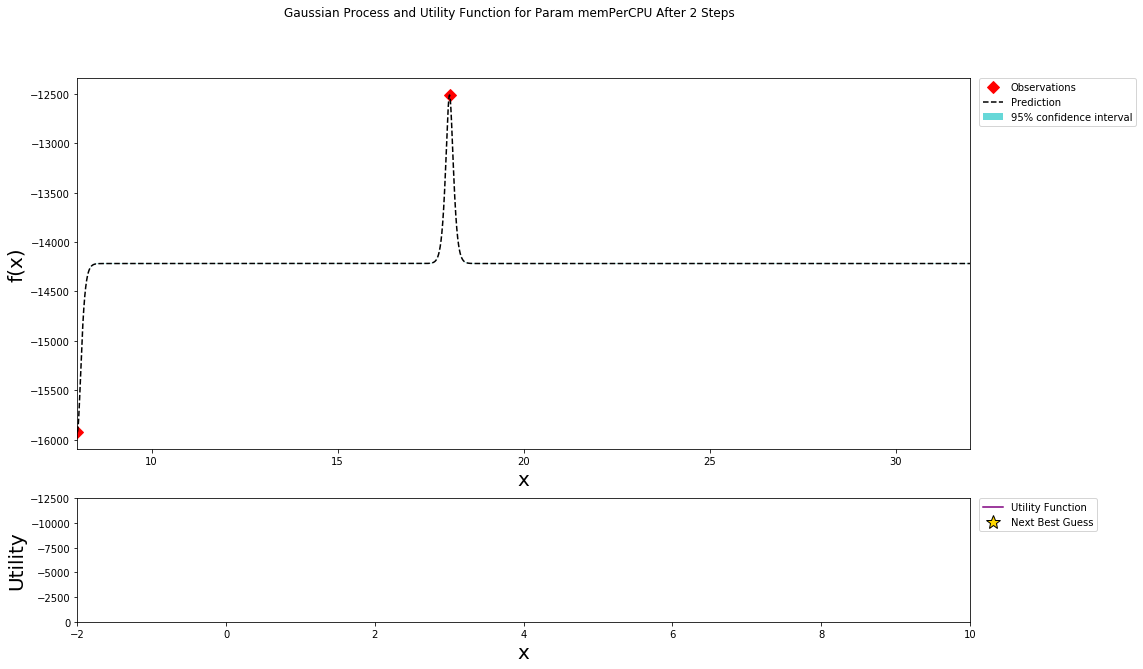

In [72]:
plot_gp(optimizer, orig_utility, params, 'memPerCPU')

our utility function, UCB, is looking optimistically at the CI and trying to find potential best improvement but the CI is so tight to our estimated function, and our estimated function is so ~weird~ that this won't work  
ie, the flat line between the points keeps them all equally good, except for a very small range where it spikes in the function estimation

Thus, the gaussian process regressor is what needs to be fixed.  

sklearn's GPR: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

In [93]:
# get data points into lists

dataPoints = []
with open('./bayes_logs.json', 'r') as f:
    dataPoints = list(map(json.loads, f.readlines()))

cpu_obs = np.array([pt['params']['nCPUs'] for pt in dataPoints]).reshape(-1, 1)
mem_obs = np.array([pt['params']['memPerCPU'] for pt in dataPoints]).reshape(-1, 1)
targ_obs = np.array([pt['target'] for pt in dataPoints]).reshape(-1, 1)

cpu_xrange = np.linspace(params['nCPUs'][0], params['nCPUs'][1], 10000).reshape(-1, 1)
mem_xrange = np.linspace(params['memPerCPU'][0], params['memPerCPU'][1], 10000).reshape(-1, 1)

In [118]:
mem_xrange

array([[ 8.        ],
       [ 8.00240024],
       [ 8.00480048],
       ...,
       [31.99519952],
       [31.99759976],
       [32.        ]])

In [140]:
def fitAndPlot(gp, x_obs, y_obs, xrange):
    gp.fit(x_obs, y_obs)
    mu, sigma = gp.predict(xrange, return_std=True)
    mu_rav, sigma_rav = mu.ravel(), sigma.ravel()
    plt.plot(xrange, mu)
    plt.fill_between(xrange.ravel(), mu_rav - sigma_rav, mu_rav + sigma_rav, alpha=0.5)
    plt.plot(x_obs.flatten(), targ_obs, 'D', markersize=8, label=u'Observations', color='r')
    plt.xlim((xrange[0], xrange[-1]))
    plt.show()

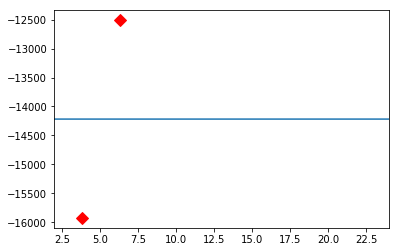

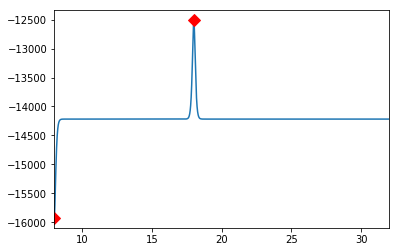

In [141]:
# same gp as in bayes opt package
bo_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(bo_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(bo_gp, mem_obs, targ_obs, mem_xrange)

Seems like I need to change the kernel being used by the GP

https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels



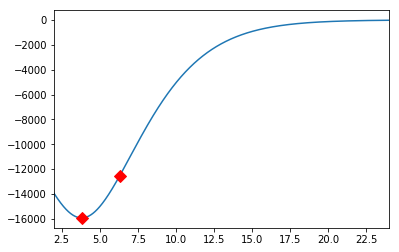

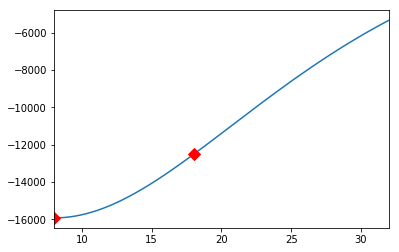

In [143]:
# modified gp
# set normalize_y to False
# don't think this should be the right solution, see comment on parameter below

# normalize_y : boolean, optional (default: False)
# Whether the target values y are normalized, i.e., the mean of the observed target values become zero. 
# This parameter should be set to True if the target values’ mean is expected to differ considerable from zero.
# When enabled, the normalization effectively modifies the GP’s prior based on the data, which contradicts the
# likelihood principle; normalization is thus disabled per default.

# our mean is definitely not centered around zero...

my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=False,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

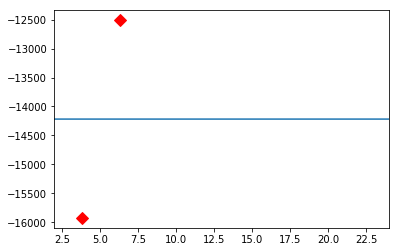

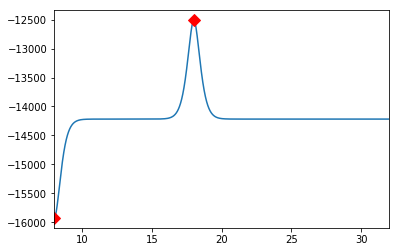

In [176]:
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5, length_scale=0.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

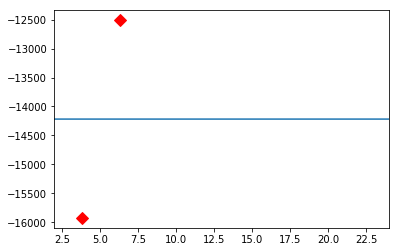

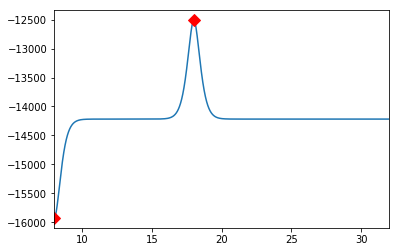

In [177]:
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5, length_scale=0.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)